In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
import gmpy2
import statistics as st
import pickle
from src.PDE_Solver import PDESolver_nd
from src.solver_2d import false_transient_one_iteration_cpp,false_transient_one_iteration_python
from src.derivative import derivatives_2d, derivative_1d
from joblib import Parallel, delayed
from src.supportfunctions import finiteDiff, PDESolver_2d
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300


In [2]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
    return "Elapsed time : %f seconds.\n" %tempTimeInterval

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)
    
TicToc2 = TicTocGenerator() # create another instance of the TicTocGen generator

def toc2(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc2
    tempTimeInterval = next(TicToc2)
    if tempBool:
        print( "Elapsed time total loop: %f seconds.\n" %tempTimeInterval )
    return "Elapsed time total loop: %f seconds.\n" %tempTimeInterval

def tic2():
    # Records a time in TicToc2, marks the beginning of a time interval
    toc2(False)

In [3]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
# y grid
# λ = np.log(2)/6

In [4]:
y1_step = .02
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [5]:
def solve_prep(y1_mat, y2_mat, γ3, λ, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5

    while lhs_error > tol and episode  < max_iter:

        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-10] = 1e-10
        ems = ems_new*fraction + ems_old*(1 - fraction)
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])    
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print(episode)
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start)
    print_results="Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1])
    print(print_results)
    result = dict(v0=v0, ems=ems, πa=πa, episode = episode, rhs_error = rhs_error, lhs_error= lhs_error )
    return (result)

In [ ]:
tol      = 1e-6
ϵ        = 0.1
max_iter = 5000
fraction = .2
γ3_list  = np.linspace(0., 1./3, 10)
λ_list   =  np.linspace(1, 1, 1)
testing_name = 4011

safe = Parallel(n_jobs=-2)(delayed(solve_prep)(y1_mat, y2_mat, 
                                              γ3, λ, tol, ϵ, max_iter, fraction) for λ in λ_list for γ3 in γ3_list)       


In [46]:
i=0
for λ in λ_list:
    for γ3 in γ3_list:
        ϕ_list   = np.zeros((1, len(y1_grid), len(y2_grid)))            
        ems_list = np.zeros((1, len(y1_grid), len(y2_grid)))
        
        ϕ_list          = safe[i]['v0']
        ems_list        = safe[i]['ems']
        πa_list         = safe[i]['πa']
        episode_list    = safe[i]['episode']
        rhs_list        = safe[i]['rhs_error']
        lhs_list        = safe[i]['lhs_error']
        
        names     = ['Episode', 'RHS_ERROR', 'LHS_ERROR'] 
        epi_error = pd.DataFrame([(episode_list), 
                                        (rhs_list), (lhs_list)], index=names)
        
        newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ, γ3)
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        os.chdir(newpath)
        np.save("v_list_λ_{:.12f}_γ3_{:.12f}".format(λ, γ3), ϕ_list)
        np.save("e_list_λ_{:.12f}_γ3_{:.12f}".format(λ, γ3), ems_list)
        np.save('Parameter_specifications_λ_{:.12f}_γ3_{:.12f}'.format(λ, γ3), (λ, γ3,
                                                         tol, ϵ, max_iter, fraction, 
                                                         y1_step, y2_step))
        np.save('Episode_Error_λ_{:.12f}_γ3_{:.12f}'.format(λ, γ3), epi_error)
        np.load('Episode_Error_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ, γ3))
        i=i+1

In [50]:
γ3 = γ3_list[9]
newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ, γ3)  
os.chdir(newpath)
np.load('Episode_Error_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ, γ3))


array([[5.00000000e+03],
       [2.08532103e-02],
       [4.81449552e-04]])

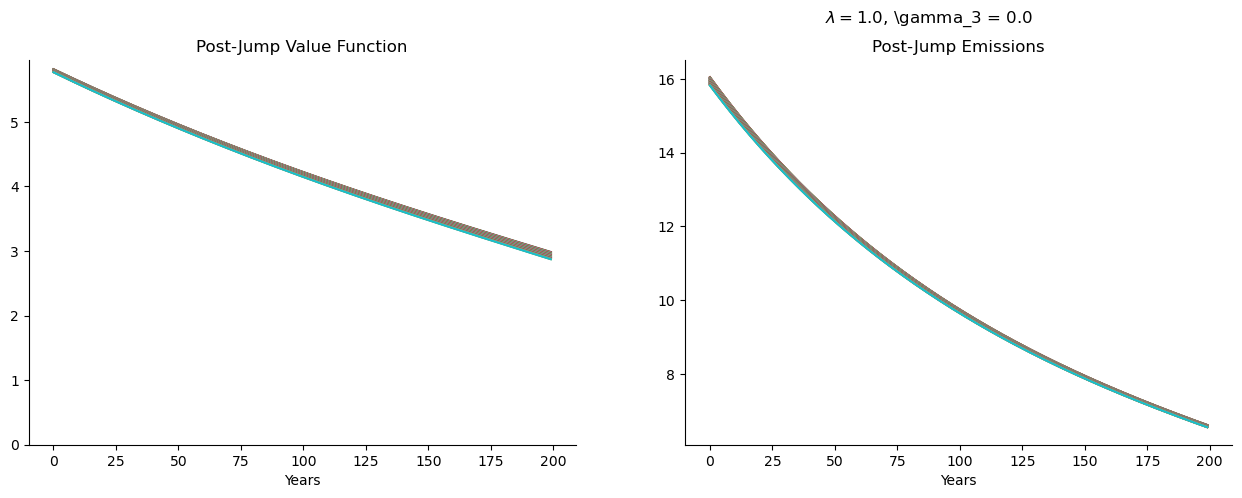

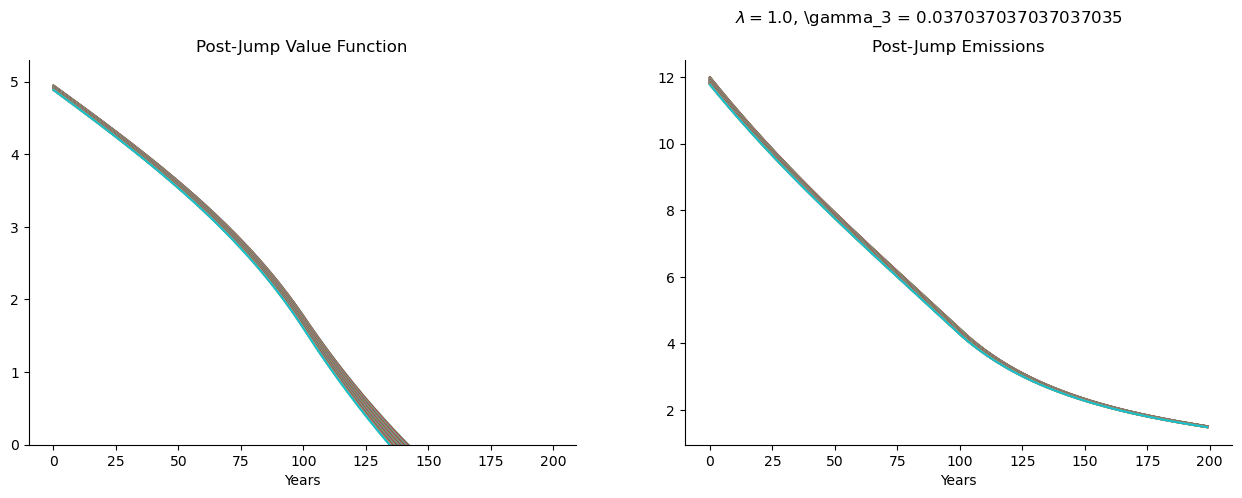

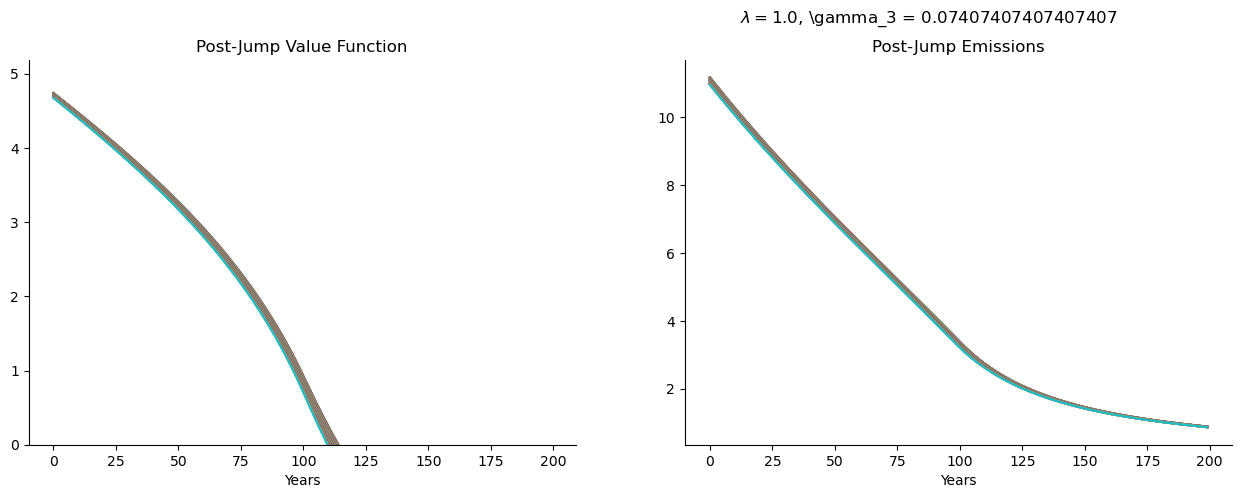

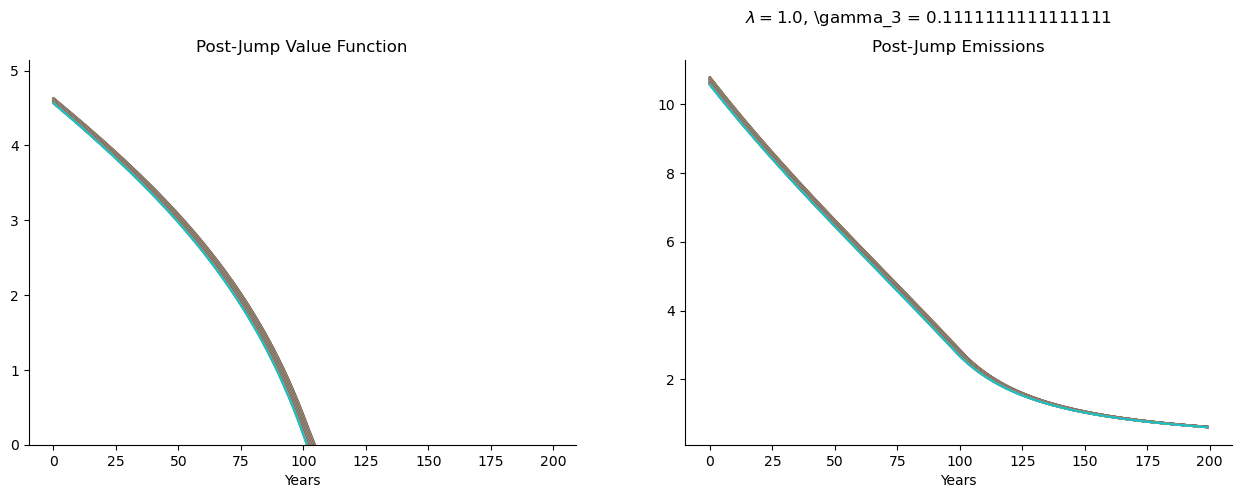

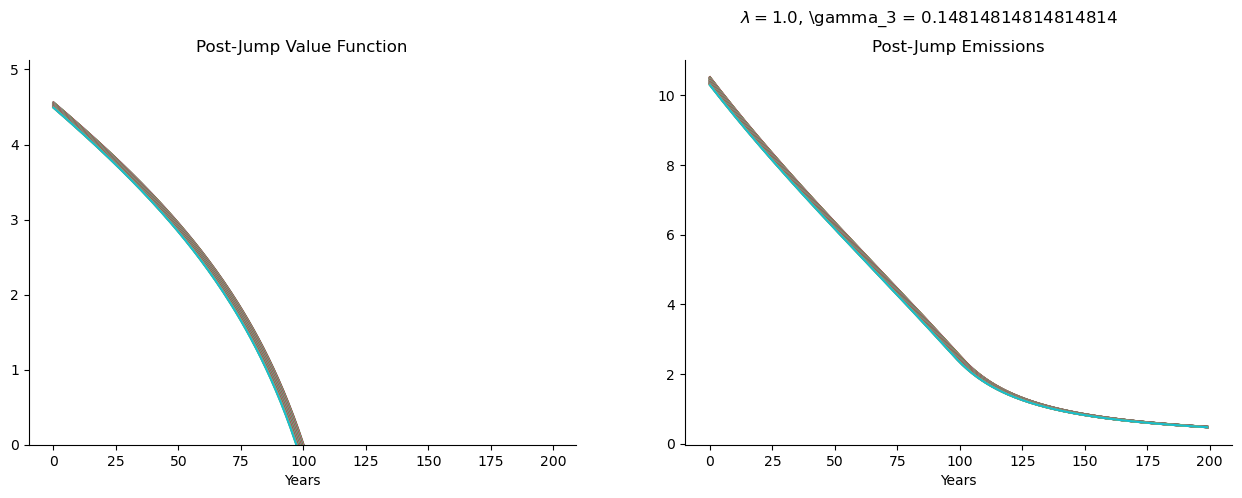

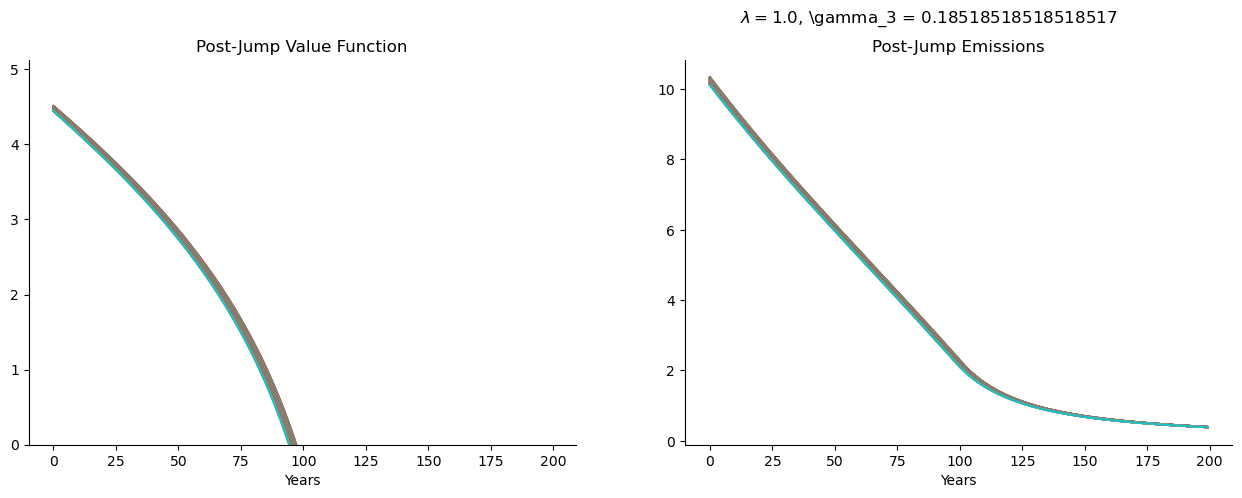

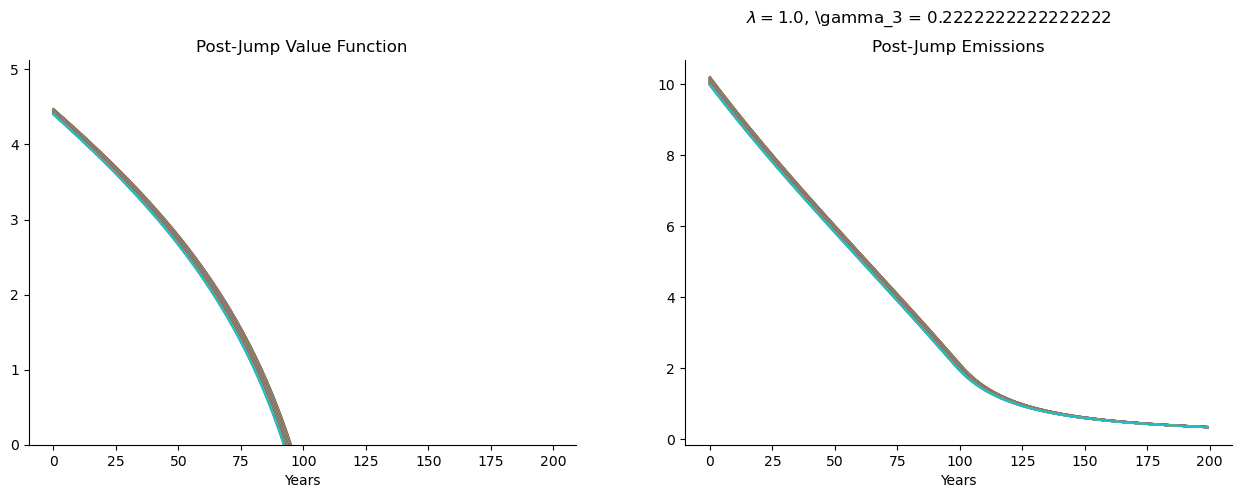

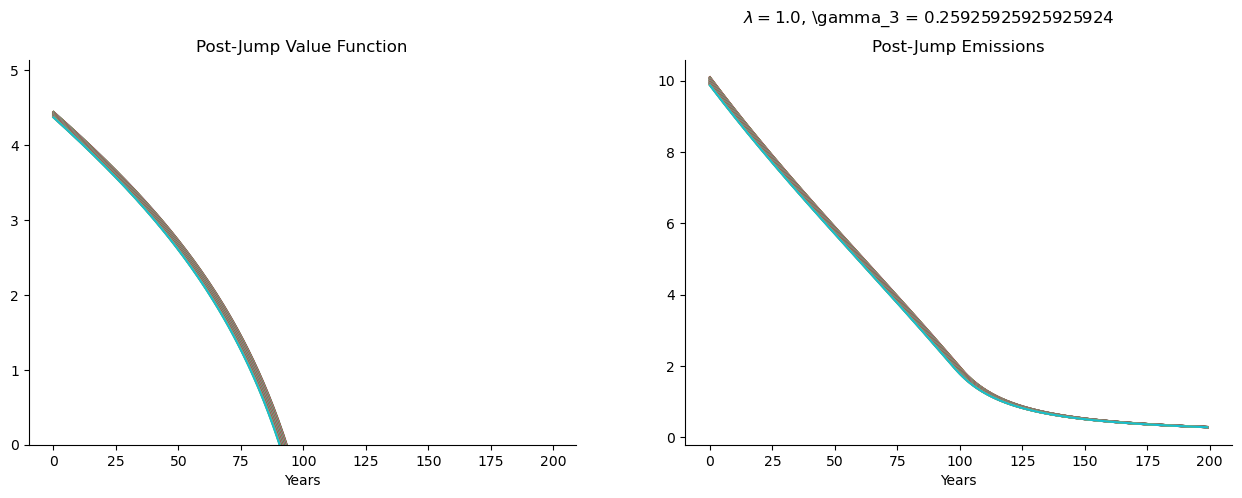

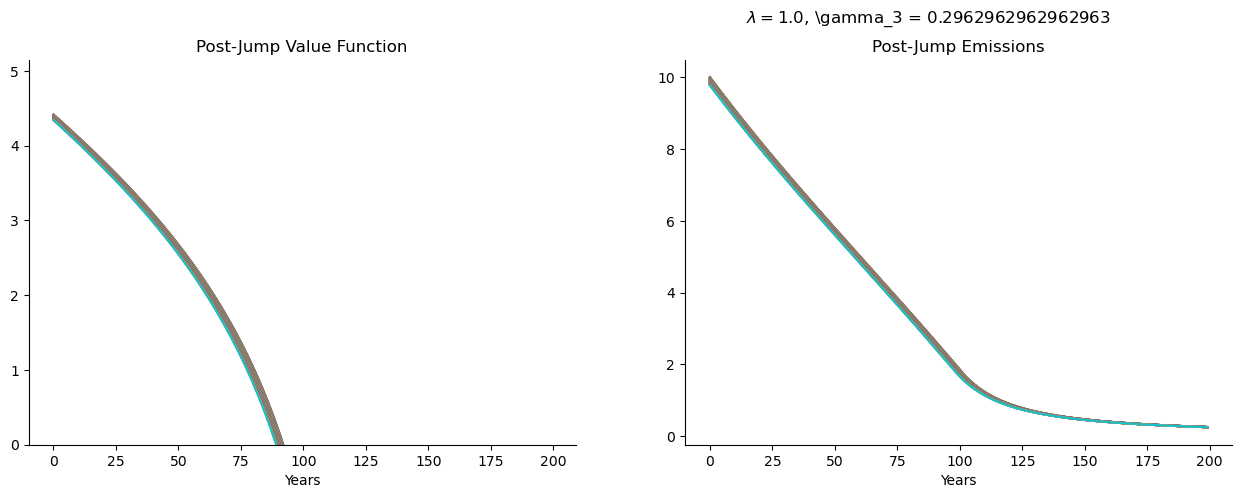

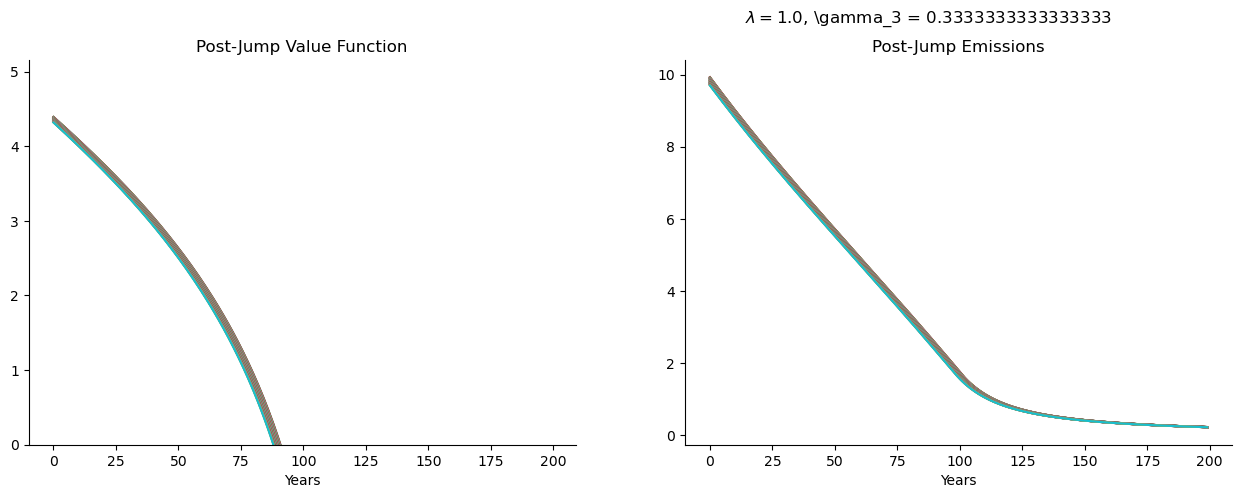

In [11]:
for λ in λ_list:
    for γ3 in γ3_list:
        newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ, γ3)
        os.chdir(newpath)
        ϕ_plot  = np.load('v_list_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ, γ3))
        ems_plot= np.load("e_list_λ_{:.12f}_γ3_{:.12f}.npy".format(λ, γ3))
        fig = plt.figure(figsize=(24, 5))
        fig.suptitle(f"$\lambda = {λ}$, \gamma_3 = {γ3}")
        plt.subplot(131)
        plt.title("Post-Jump Value Function")
        plt.plot(ϕ_plot)
        plt.ylim(0)
        plt.xlabel("Years")
        plt.subplot(132)
        plt.title("Post-Jump Emissions")
        plt.plot(ems_plot)
        plt.xlabel("Years")
        plt.savefig("EV_plot_λ_{:.12f}_γ3_{:.12f}.png".format(λ, γ3))
        plt.show()

In [23]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
stateSpace2 = np.hstack([y1_mat_cap.reshape(-1,1, order='F'), y2_mat_cap.reshape(-1,1,order='F')])
loc_2 = np.abs(y1_grid - 2.).argmin()
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)

In [78]:
def solve_prep_pre(y1_mat_cap, y2_mat_cap, γ3_list, λ, ξp, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05, vfraction =0.05):
    if np.isscalar == True:
        γ3_len = 1
    else:
        γ3_len = len(γ3_list)
    dmg_weight = np.ones(γ3_len) / γ3_len
    i = 0
    ϕ_list = np.zeros((γ3_len, len(y1_grid), len(y2_grid)))
    for γ3 in γ3_list:
        newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/gamma_3_{:.12f}'.format(testing_name,λ, γ3)
        os.chdir(newpath)
        ϕ_list[i]  = np.load('v_list_λ_{:.12f}_γ3_{:.12f}.npy'.format(λ, γ3))
        i=i+1
    ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)
    ϕ_equiv = -ξp * np.log(ϕ_weight)
    πd_o = np.ones((γ3_len, num_y1, num_y2)) / γ3_len
    πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
    θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    dΛ1 = γ1 + γ2 * y1_mat_cap

    r1 = 1.5
    r2 = 2.5
    y_lower = 1.5
    Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                      1) * (y1_mat_cap >= y_lower)

    # initiate v and control
    ems = η
    ems_old = ems
    lhs_error = 1
    episode = 0
    v0 = ϕ_equiv[:num_y1]
    v_m = np.zeros(πd_o.shape)
    g_m = np.zeros(πd_o.shape)
    g_m_old =np.zeros(πd_o.shape)
    for i in range(γ3_len):
        v_m[i] = ϕ_list[i][loc_2]

    while lhs_error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
        v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
        # updating controls
        weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o * np.exp(weight)
        πa[πa < 1e-15] = 1e-15
        πa = πa / np.sum(πa, axis=0)
        ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new * fraction + ems_old * (1-fraction) 
        
        g_m_new = np.exp(1 / ξp * (v0 - v_m))
        g_m = g_m_new * vfraction + g_m_old * (1-vfraction)
        g_m[g_m< 1e-15]= 1e-15
        # HJB coefficient
        A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
        B_y1 = y2_mat_cap
        B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
        C_yy1 = np.zeros(y1_mat_cap.shape)
        C_yy2 = np.zeros(y1_mat_cap.shape)
        D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
            πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
                πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                    πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
        phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

        rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
        ems_old = ems
        g_m_old = g_m
        episode += 1
    epi_print = 'Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error)
    print(epi_print)
    result = dict(v0=v0, ems=ems, g_m=g_m,v0_dy1=v0_dy1, 
                  v0_dy2=v0_dy2, episode = episode, lhs_error = lhs_error, rhs_error= rhs_error )
    return (result)



In [79]:
tol       = 1e-6
ϵ         = 0.01
max_iter  = 5000
fraction  = 0.1
vfraction = 1
ξp=1
γ3_len           = len(γ3_list)
res_list= Parallel(n_jobs=-2)(delayed(solve_prep_pre)(y1_mat_cap, y2_mat_cap, 
                            γ3_list, λ, ξp, tol, ϵ, max_iter, fraction, vfraction) for λ in λ_list)

In [80]:
i=0
for λ in λ_list:
    rest_pre_list_2  = res_list
    v0_pre_list      = rest_pre_list_2[i]['v0']
    ems_pre_list     = rest_pre_list_2[i]['ems']
    gm_pre_list      = rest_pre_list_2[i]['g_m']
    v0_dy1_list      = rest_pre_list_2[i]['v0_dy1']
    v0_dy2_list      = rest_pre_list_2[i]['v0_dy2']
    episode_pre_list = rest_pre_list_2[i]['episode']
    rhs_pre_list     = rest_pre_list_2[i]['rhs_error']
    lhs_pre_list     = rest_pre_list_2[i]['lhs_error']
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    os.chdir(newpath)
    np.save("v0_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ, γ3_len), v0_pre_list)
    np.save("ems_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ, γ3_len), ems_pre_list)
    np.save("gm_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ, γ3_len), gm_pre_list)
    np.save("v0_dy1_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ, γ3_len), v0_dy1_list)
    np.save("v0_dy2_pre_list_λ_{:.12f}_γ3_len_{:.12f}".format(λ, γ3_len), v0_dy2_list)
    np.save('Parameter specifications_λ_{:.12f}_γ3_len_{:.12f}'.format(λ, γ3_len), (λ, γ3_list, λ,
                                                 tol, ϵ, max_iter, fraction, 
                                                 y1_step, y2_step))
    np.save('Count Timer and Episode Length_λ_{:.12f}_γ3_len_{:.12f}'.format(λ, γ3_len), [episode_pre_list, rhs_pre_list, lhs_pre_list])
    i = i+1

/Users/samuelzhao/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [81]:
np.load('Count Timer and Episode Length_λ_{:.12f}_γ3_len_{:.12f}.npy'.format(λ, γ3_len))


array([5.00000000e+03, 5.49148332e-01, 5.53599890e-01])

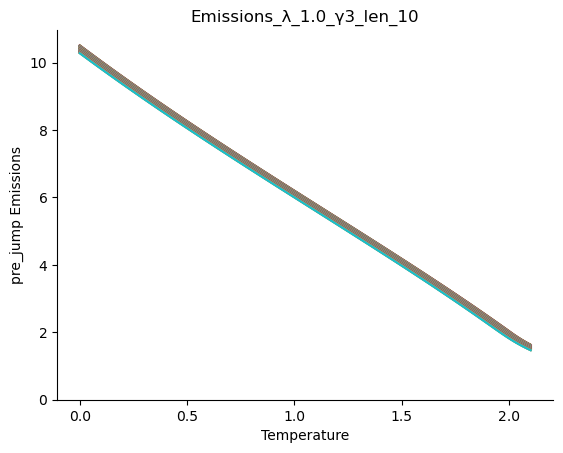

In [82]:
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    ems_pre_list_plot=np.load('ems_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy'.format(λ, γ3_len))
    fig = plt.figure()
    plt.title(f"Emissions_λ_{λ}_γ3_len_{γ3_len}")
    plt.plot(y1_grid_cap, ems_pre_list_plot)
    plt.ylim(0)
    plt.ylabel("pre_jump Emissions")
    plt.xlabel("Temperature")
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("E_pre_plot_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()


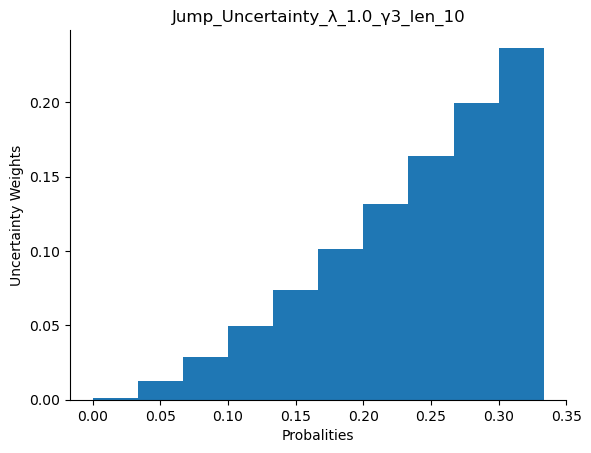

In [57]:
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    g_m_plot=np.load("gm_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy".format(λ, γ3_len))
    g_i = g_m_plot[:, -1, 2]
    fig = plt.figure()
    plt.title(f"Jump_Uncertainty_λ_{λ}_γ3_len_{γ3_len}")
    plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
    plt.ylabel("Uncertainty Weights")
    plt.xlabel("Probalities")
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing_python{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("g_m_pre_plot_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()


In [ ]:
#computation of derivatives
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    v0_dy1=np.load("v0_dy1_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy".format(λ, γ3_len))
    v0_dy2=np.load("v0_dy2_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy".format(λ, γ3_len))
    
    
    plt.title("First order derivative, with respect to $y_1$")
    plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
    plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
    plt.xlabel(r"$y_1$")
    plt.legend()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("1st_der_y1_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()
    
    
    plt.title("First order derivative, with respect to $y_2$")
    plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
    plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
    plt.xlabel(r"$y_1$")
    plt.legend()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("1st_der_y2_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()
    
    
    plt.title("First order derivative, with respect to $y_2$")
    plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
    plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
    plt.xlabel(r"$y_2$")
    plt.legend()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("1st_der_y2_under_y2_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()
    
    

In [ ]:
from scipy import interpolate
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [ ]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [ ]:
for λ in λ_list:
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    ems=np.load('ems_pre_list_λ_{:.12f}_γ3_len_{:.12f}.npy'.format(λ, γ3_len))
    et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                      y2_grid,
                                                      ems,
                                                      λ,
                                                      θ=np.mean(θ_list),
                                                      y1_0 = 1.1,
                                                      y2_0=np.mean(θ_list),
                                                      T=93
                                                     )
    simul = {
        "et": et_prejump,
        "y1t": y1t_prejump,
        "y2t": y2t_prejump,
    }

    pickle.dump(simul, open("simul_2", "wb"))
    fig = plt.figure(figsize=(24, 5))
    fig.suptitle(f"$\lambda = {λ}$")
    plt.subplot(131)
    plt.title("Emission, no jump")
    plt.plot(et_prejump)
    plt.ylim(0,10)
    plt.xlabel("Years")
    plt.subplot(132)
    plt.xlabel("Years")
    plt.title(r"$Y_t^1$, no jump")
    plt.plot(y1t_prejump)
    plt.ylim(1)
    plt.subplot(133)
    plt.title(r"$Y_t^2$")
    plt.plot(y2t_prejump)
    plt.ylim(0, 0.02)
    plt.xlabel("Years")
    plt.tight_layout()
    newpath = r'/Users/samuelzhao/Documents/GitHub/ClimateUncertainty-twostate/lambda_testing{:.12f}/lambda_{:.12f}/pre_jump/gamma_3_len_{:.12f}'.format(testing_name,λ,γ3_len)
    os.chdir(newpath)
    plt.savefig("e_y1_y2_λ_{:.12f}_γ3_len_{:.12f}.png".format(λ, γ3_len))
    plt.show()